In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import hist
import vector
import os
import subprocess
import gc
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad
print("uproot version", uproot.__version__)
print("awkward version", ak.__version__)
print("numpy version", np.__version__)
print("matplotlib version", matplotlib.__version__)
print("hist version", hist.__version__)
print("vector version", vector.__version__)
#print("os version", os.__version__)
#print("subprocess version", subprocess.__version__)
#print("gc version", gc.__version__)
print("pandas version", pd.__version__)

uproot version 5.0.12
awkward version 2.4.3
numpy version 1.25.2
matplotlib version 3.8.0
hist version 2.7.2
vector version 1.1.1
pandas version 1.5.3


In [2]:
vector.register_awkward() 

In [3]:
SAMPLE_RUNS = sorted([290323, 290327, 290848, 291361, 291360, 291362, 290853, 290860, 291373, 290374, 
                      290375, 291399, 291400, 290894, 290895, 290404, 291943, 291944, 291948, 291953, 
                      290932, 290423, 291447, 290935, 290425, 290427, 291451, 291453, 291976, 291982, 
                      290456, 290458, 290459, 291482, 291485, 290975, 290980, 290469, 292012, 291002, 
                      291003, 291004, 291005, 290501, 292040, 292060, 292061, 292062, 291041, 290539, 
                      290540, 292075, 292077, 292080, 290549, 290553, 291590, 292106, 292108, 292109, 
                      292115, 290590, 291618, 291622, 291624, 292140, 290612, 292160, 292162, 292163, 
                      292164, 292166, 290632, 291657, 292168, 292192, 290658, 290660, 291690, 291692, 
                      291694, 291698, 291706, 290687, 290692, 290696, 290699, 292242, 292265, 291755, 
                      292269, 292270, 291760, 292273, 292274, 290742, 291769, 291263, 290764, 290766, 
                      291283, 291284, 291285, 291795, 291796, 290776, 291803, 290787])

In [4]:
def integral(histo: hist.Hist, start: float, stop: float):
    start_bin = histo.axes[0].index(start)  
    stop_bin = histo.axes[0].index(stop)
    return histo[start_bin:stop_bin].sum()

def getTracksEvents(events):
    return ak.zip({
        "px":events["Muon_Px"],
        "py":events["Muon_Py"],
        "pz":events["Muon_Pz"],
        "E":events["Muon_E"],
        "charge":events["Muon_Charge"],
        "thetaAbs":events["Muon_thetaAbs"],
        "matched":events["Muon_matchedTrgThreshold"],
        "code":events["Muon_MCPDGCode"],
        "label":events["Muon_MCLabel"]},
         with_name='Momentum4D')

def getTracksGen(events):
    return ak.zip({
        "px":events["Muon_GenPx"],
        "py":events["Muon_GenPy"],
        "pz":events["Muon_GenPz"],
        "E":events["Muon_GenE"],
        "label":events["Muon_GenLabel"],
        "code":events["Muon_GenMotherPDGCode"]},
        with_name='Momentum4D')

def Momentum4D(events):
    return ak.zip({
        "px": events["0"].px + events["1"].px,
        "py": events["0"].py + events["1"].py,
        "pz": events["0"].pz + events["1"].pz,
        "E" : events["0"].E  + events["1"].E},
        with_name="Momentum4D")


def scan(dataDescription, 
              hMagGen:hist.Hist, hPhiGen:hist.Hist, hEtaGen:hist.Hist, hYGen:hist.Hist, hPtGen:hist.Hist, hMassGen:hist.Hist, hMass2Gen:hist.Hist,
              hMagEvents:hist.Hist, hPhiEvents:hist.Hist, hEtaEvents:hist.Hist, hYEvents:hist.Hist, hPtEvents:hist.Hist, hMassEvents:hist.Hist, hMass_OSMuon:hist.Hist, hMass_LSMuon:hist.Hist,
              eventSelectorGen = lambda x:[True]*len(x), trackSelectorGen = lambda x:[True]*len(x), pairSelectorGen = lambda x:[True]*len(x),
              eventSelectorEvents = lambda x:[True]*len(x), trackSelectorEvents = lambda x:[True]*len(x), pairSelectorEvents = lambda x:[True]*len(x),
              verbose:bool = False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
        print(dir(vector.backends.awkward.MomentumArray4D))
    """
    
    nEntriesGen = nGoodEventsGen = nGoodTracksGen = nGoodEntriesGen = nJPsiGen = nPairsGen = nGoodGen= 0
    PDGGen = PDG = LabelGen = Label = []
    nEntries = nGoodEvents = nGoodTracks = nGoodEntries = AxE = nPairs = nOS = nGoodOS = nLS = nGoodLS = nJPsiEvents = i_stat = 0
    
    for batchGen, batchEvents in zip(uproot.iterate(dataDescription + "genTree", ["Muon_GenE", "Muon_GenPx", "Muon_GenPy", "Muon_GenPz", "Muon_GenLabel", "Muon_GenMotherPDGCode"], report = True),
                                    uproot.iterate(dataDescription + "eventsTree", ["isCINT", "isCMUL", "isCMSL", "Muon_Px", "Muon_Py", "Muon_Pz", "Muon_E", "Muon_Charge", "Muon_thetaAbs", "Muon_matchedTrgThreshold", "Muon_MCLabel", "Muon_MCPDGCode"], report = True)):

        eventsGen = batchGen[0] # batch[1] is the report info
        events = batchEvents[0]
        #eventsGen[0:10].show()
        #events[0:10].show()

        if (len(eventsGen) < 1000) | (len(events) < 1000):
            print("something is wrong", batchGen[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEventsGen = eventsGen[eventSelectorGen(eventsGen)]
        tracksGen = getTracksGen(goodEventsGen)
        goodTracksGen = tracksGen[trackSelectorGen(tracksGen)]
        #goodTracksGen[0:10].show()
        
        hMagGen.fill(ak.flatten(goodTracksGen.p))
        hPhiGen.fill(ak.flatten(goodTracksGen.phi))
        hPtGen.fill(ak.flatten(goodTracksGen.pt))
        hYGen.fill(ak.flatten(goodTracksGen.rapidity))
        hEtaGen.fill(ak.flatten(goodTracksGen.eta))
        hMassGen.fill(ak.flatten(goodTracksGen.mass))
        
        pairsGen = ak.combinations(goodTracksGen, 2)
        #pairsGen[0:10].show()
        Gen = Momentum4D(pairsGen)
        #Gen[0:10].show()
        goodGen = Gen[pairSelectorGen(Gen)]
        #goodGen[0:10].show()
        
        hMass2Gen.fill(ak.flatten(goodGen.mass))
        
        
        
        isJPsi = ak.num(goodTracksGen) > 0
        #print(isJPsi[0:10].show())
        events2 = ak.zip({"isJPsi":isJPsi, "isCINT":events["isCINT"], "isCMUL":events["isCMUL"], "isCMSL":events["isCMSL"], "Muon_Px":events["Muon_Px"], "Muon_Py":events["Muon_Py"], 
                          "Muon_Pz":events["Muon_Pz"], "Muon_E":events["Muon_E"], "Muon_Charge":events["Muon_Charge"], "Muon_thetaAbs":events["Muon_thetaAbs"],
                          "Muon_matchedTrgThreshold":events["Muon_matchedTrgThreshold"], "Muon_MCLabel":events["Muon_MCLabel"], "Muon_MCPDGCode":events["Muon_MCPDGCode"]})
                          
        
        #print(events2[0:10].show())
        goodEvents = events2[eventSelectorEvents(events2)]
        tracks = getTracksEvents(goodEvents)
        goodTracks = tracks[trackSelectorEvents(tracks)]
        #goodTracks[0:10].show()
        
        
        pairs = ak.combinations(goodTracks, 2)
        
        condition_OS = np.logical_or(np.logical_and(pairs["0"].code ==  13, pairs["1"].code == -13),
                                     np.logical_and(pairs["0"].code == -13, pairs["1"].code ==  13))
        muons_OS = pairs[condition_OS]
        OS = Momentum4D(muons_OS)
        goodOS = OS[pairSelectorEvents(OS)]
    
        
        condition_LS = np.logical_or(np.logical_and(pairs["0"].code == -13, pairs["1"].code == -13),
                                     np.logical_and(pairs["0"].code ==  13, pairs["1"].code ==  13))
        muons_LS = pairs[condition_LS]
        LS = Momentum4D(muons_LS)
        goodLS = LS[pairSelectorEvents(LS)]

        
        hMagEvents.fill(ak.flatten(goodTracks.p))
        hPhiEvents.fill(ak.flatten(goodTracks.phi))
        hPtEvents.fill(ak.flatten(goodTracks.pt))
        hYEvents.fill(ak.flatten(goodTracks.rapidity))
        hEtaEvents.fill(ak.flatten(goodTracks.eta))
        hMassEvents.fill(ak.flatten(goodTracks.mass))
        
        hMass_OSEvents.fill(ak.flatten(goodOS.mass))
        hMass_LSEvents.fill(ak.flatten(goodLS.mass))
        
        
        nEntriesGen += len(eventsGen)
        nGoodEventsGen += len(goodEventsGen)
        nGoodTracksGen += len(ak.flatten(goodTracksGen))
        nGoodEntriesGen += list(ak.num(goodTracksGen) > 0).count(True)
        nPairsGen += len(ak.flatten(pairsGen))
        nGoodGen += len(ak.flatten(goodGen))
        PDGGen = np.union1d(PDG, ak.flatten(goodTracksGen.code))
        LabelGen = np.union1d(LabelGen, ak.flatten(goodTracksGen.label))
        
        nEntries += len(events)
        nGoodEvents += len(goodEvents)
        nGoodTracks += len(ak.flatten(goodTracks))
        nGoodEntries += list(ak.num(goodTracks) > 0).count(True)
        nPairs += len(ak.flatten(pairs))
        nOS += len(ak.flatten(OS))
        nGoodOS += len(ak.flatten(goodOS))
        nLS += len(ak.flatten(LS))
        nGoodLS += len(ak.flatten(goodLS))
        PDG = np.union1d(PDG, ak.flatten(goodTracks.code))
        Label = np.union1d(Label, ak.flatten(goodTracks.label))
        
        nJPsiEvents += len(ak.flatten(goodOS))
        nJPsiGen += len(ak.flatten(goodGen))
        AxE = nJPsiEvents / nJPsiGen
        i_stat = (math.sqrt(nGoodOS)/nGoodOS)+(math.sqrt(nGoodGen)/nGoodGen)

        if verbose:
            #print("Statistiques Generees")
            print(batchGen[1])
            print("Entries: ", nEntries)
            print("Good Events: ", nGoodEventsGen)
            print("Good Tracks: ", nGoodTracksGen)
            print("Good Entries: ", nGoodEntriesGen)
            print("Pairs: ", nPairsGen)
            print("Good Pairs: ", nGoodGen)
            #print("PDG: ", PDGGen)
            #print("Label: ", LabelGen)
            print("----------------------------")
            
            #print("Statistiques Detectees")
            print(batchEvents[1])
            print("Entries: ", nEntries)
            print("Good Events: ", nGoodEvents)
            print("Good Tracks: ", nGoodTracks)
            print("Good Entries: ", nGoodEntries)
            print("Pairs: ", nPairs)
            print("OS: ", nOS)
            print("Good OS:", nGoodOS)
            #print("LS: ", nLS)
            #print("Good LS:", nGoodLS)
            #print("PDG: ", PDG)
            #print("Label: ", Label)
            print("----------------------------")
            
            print("J/Psi gen: ", nJPsiGen)
            print("J/Psi events: ", nJPsiEvents)
            #print("-------> AxE: ", AxE)
            print("---------------------------------------------------------------------------------------")
        gc.collect()
        
    return nEntriesGen, nGoodEventsGen, nGoodTracksGen, nGoodEntriesGen, nJPsiGen, nPairsGen, nGoodGen, PDGGen, LabelGen, nEntries, nGoodEvents, nGoodTracks, nGoodEntries, nPairs, nOS, nGoodOS, nLS, nGoodLS, PDG, Label, AxE, nJPsiEvents, i_stat

In [5]:
hMagGen = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhiGen = hist.Hist(hist.axis.Regular(bins = 200, start = -22/7, stop = 22/7, name = '$\phi$'))
hEtaGen = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hYGen = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$y$'))
hPtGen = hist.Hist(hist.axis.Regular(bins = 200, start = 0, stop = 10, name = '$p_T$'))
hMassGen = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))
hMass2Gen = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

hMagEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 100, name = '$|p|$'))
hPhiEvents = hist.Hist(hist.axis.Regular(bins = 200, start = -22/7, stop = 22/7, name = '$\phi$'))
hEtaEvents = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$\eta$'))
hYEvents = hist.Hist(hist.axis.Regular(bins = 100, start = -6, stop = 0, name = '$y$'))
hPtEvents = hist.Hist(hist.axis.Regular(bins = 200, start = 0, stop = 10, name = '$p_T$'))
hMassEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 0, stop = 0.2, name = '$m_{\mu}$'))
hMass_OSEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))
hMass_LSEvents = hist.Hist(hist.axis.Regular(bins = 100, start = 1.5, stop = 5, name = '$m_{\mu \mu}$'))

In [6]:
%%time


EntriesGen = goodEventsGen = goodTracksGen = goodEntriesGen = JPsiGen = PairsGen = goodGen = 0
PDGGen = PDG = LabelGen = Label = []
Entries = goodEvents = goodTracks = goodEntries = Pairs = OS = goodOS = LS = goodLS = JPsiEvents = 0
numerator = denominator = AxE = 0

runs = SAMPLE_RUNS
"""_ = pd.read_csv("../data/counters.online.csv")
target_columns = ["run", "duration(s)"]
runDurationWeight = _[target_columns]
filtered_runDurationWeight = runDurationWeight[runDurationWeight["run"].isin(runs)]
filtered_runDurationWeight = filtered_runDurationWeight.copy()
filtered_runDurationWeight["weight"] = filtered_runDurationWeight["duration(s)"] / filtered_runDurationWeight["duration(s)"].max()"""
_ = pd.read_csv("../data/counters.offline.csv")
target_columns = ["run", "cmul7all"]
runDurationWeight = _[target_columns]
filtered_runDurationWeight = runDurationWeight[runDurationWeight["run"].isin(runs)]
filtered_runDurationWeight = filtered_runDurationWeight.copy()
filtered_runDurationWeight["weight"] = filtered_runDurationWeight["cmul7all"] / filtered_runDurationWeight["cmul7all"].max()

for run, duration, weight in filtered_runDurationWeight.values:
    a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w = scan(dataDescription = f"/pbs/throng/training/nantes-m2-rps-exp/data/run{int(run)}.mc.root:",
                                                                                hMagGen = hMagGen, hPhiGen = hPhiGen, hEtaGen= hEtaGen, hYGen = hYGen, hPtGen = hPtGen, hMassGen = hMassGen, hMass2Gen = hMass2Gen,
                                                                                hMagEvents = hMagEvents, hPhiEvents = hPhiEvents, hEtaEvents = hEtaEvents, hYEvents = hYEvents, hPtEvents = hPtEvents, hMassEvents = hMassEvents, hMass_OSMuon = hMass_OSEvents, hMass_LSMuon = hMass_LSEvents,
                                                                                #eventSelectorGen = lambda x: ,
                                                                                trackSelectorGen = lambda x: (x.code == 443) & ((x.label == 1) | (x.label == 2)),
                                                                                #pairSelectorGen = lambda x: (x.rapidity > -2.8) & (x.rapidity < -2.5),# & (x.pt > 6) & (x.pt < 8),
                                                                                eventSelectorEvents = lambda x: (x["isCMUL"] == True) & (x["isJPsi"] == True), 
                                                                                trackSelectorEvents = lambda x: ((x.code == 13) | (x.code == -13)) & ((x.label == 1) | (x.label == 2)) & (x.eta < -2.5) & (x.eta > -4) & (x.thetaAbs < 10) & (x.thetaAbs > 2) & (x.pt > 0.5),
                                                                                #pairSelectorEvents = lambda x: (x.rapidity > -2.8) & (x.rapidity < -2.5),# & (x.pt > 6) & (x.pt < 8),
                                                                                verbose = True)
    
    EntriesGen += a
    goodEventsGen += b
    goodTracksGen += c
    goodEntriesGen += d
    PairsGen += f
    goodGen += g
    PDGGen = np.union1d(PDGGen, h)
    LabelGen = np.union1d(LabelGen, i)
    
    Entries += j
    goodEvents += k
    goodTracks += l
    goodEntries += m
    Pairs += n
    OS += o
    goodOS += p
    LS += q
    goodLS += r
    PDG = np.union1d(PDG, s)
    Label = np.union1d(Label, t)
    
    JPsiGen += e
    JPsiEvents += v
    
    numerator += weight * u
    denominator += weight
    
    print("run: ", int(run))
    print("Duration(s): ", int(duration))
    print("Weight: ", weight)
    print("-------> AxE: ", u)
    print("Incertitude stat", w)
    print("---------------------------------------------------------------------------------------")
    
AxE = numerator / denominator
I_stat=0
I_stat += w*weight*AxE / denominator


print("Entries: ", EntriesGen)
print("Good Events: ", goodEventsGen)
print("Good Tracks: ", goodTracksGen)
print("Good Entries: ", goodEntriesGen)
print("Pairs: ", PairsGen)
print("Good Pairs: ", goodGen)
print("PDG: ", PDGGen)
print("Label: ", LabelGen)
print("----------------------------")
print("Entries: ", Entries)
print("Good Events: ", goodEvents)
print("Good Tracks: ", goodTracks)
print("Good Entries: ", goodEntries)
print("Pairs: ", Pairs)
print("OS: ", OS)
print("Good OS: ", goodOS)
print("LS: ", LS)
print("Good LS: ", goodLS)
print("PDG: ", PDG)
print("Label: ", Label)
print("----------------------------")
print("J/Psi gen: ", JPsiGen)
print("J/Psi events: ", JPsiEvents)
print("-------> AxE: ", AxE)
print("Incertitude : ", I_stat)
print("---------------------------------------------------------------------------------------")

FileNotFoundError: [Errno 2] No such file or directory: '../data/counters.offline.csv'

In [7]:
print(AxE)

0


/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/tmp/ipykernel_268/2991372796.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


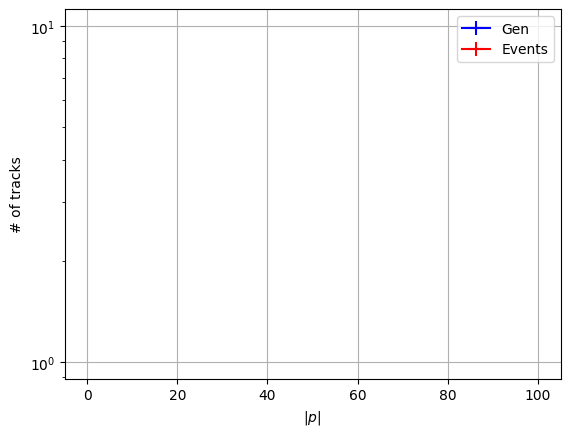

In [8]:
hMagGen.plot(color = "blue", label = "Gen")
hMagEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


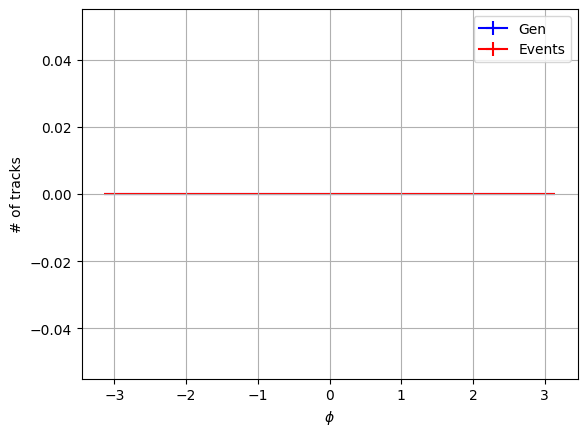

In [9]:
hPhiGen.plot(color = "blue", label = "Gen")
hPhiEvents.plot(color = "red", label = "Events")
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/tmp/ipykernel_268/1167178274.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


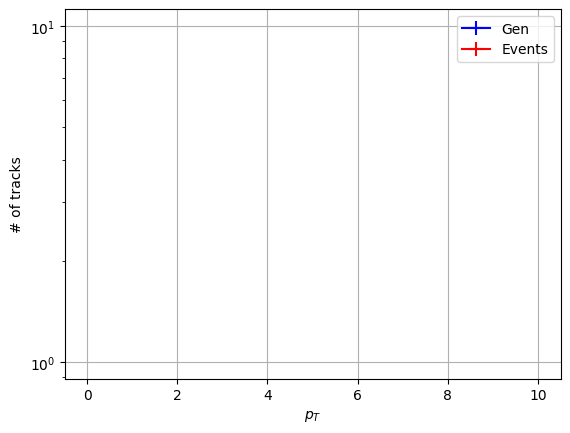

In [10]:
hPtGen.plot(color = "blue", label = "Gen")
hPtEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/tmp/ipykernel_268/2705531105.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


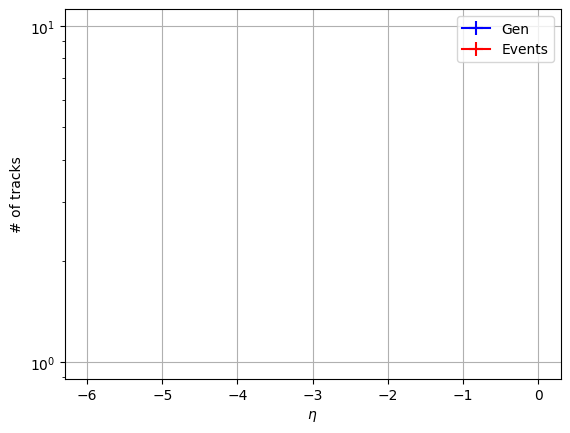

In [11]:
hEtaGen.plot(color = "blue", label = "Gen")
hEtaEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/tmp/ipykernel_268/3607888985.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


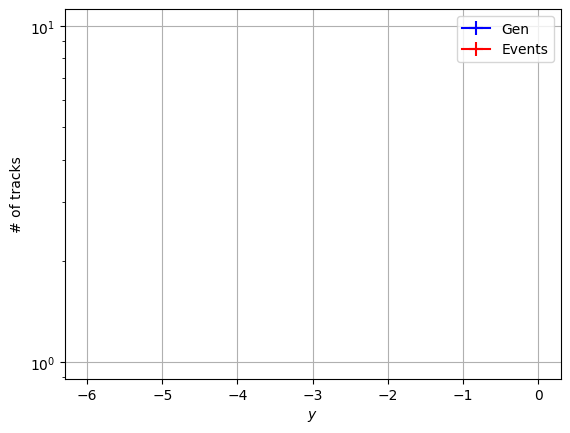

In [12]:
hYGen.plot(color = "blue", label = "Gen")
hYEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/tmp/ipykernel_268/2940552818.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


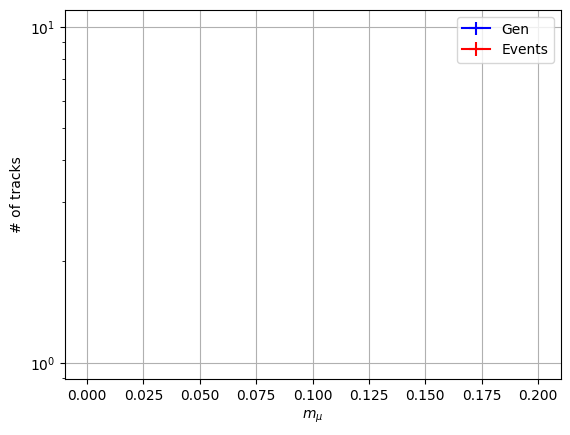

In [13]:
hMassGen.plot(color = "blue", label = "Gen")
hMassEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/tmp/ipykernel_268/1254601997.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


0.0
0.0


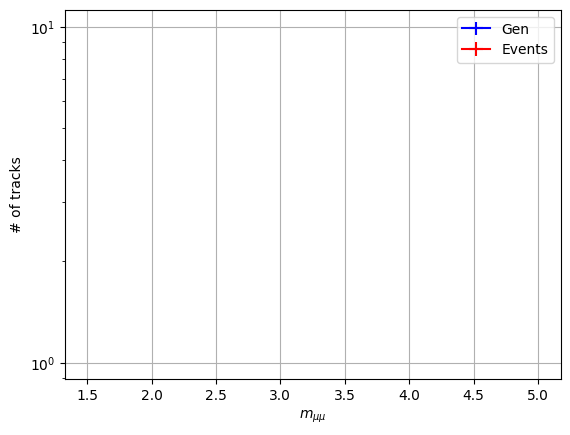

In [14]:
hMass2Gen.plot(color = "blue", label = "Gen")
hMass_OSEvents.plot(color = "red", label = "Events")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

print(integral(hMass_OSEvents, 1.5, 5.0))
print(integral(hMass2Gen, 1.5, 5.0))

/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


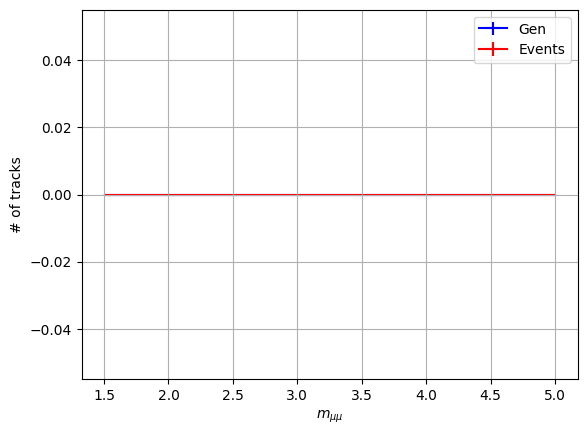

In [15]:
hMass2Gen.plot(color = "blue", label = "Gen")
hMass_OSEvents.plot(color = "red", label = "Events")
#plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()

In [16]:
ys_fit = []
#xs_ = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
#xs_ = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
""" Axes abscisses utilisables """"
xs_ = [ 0.,  0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.,  1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
 1.8, 1.9, 2.,  2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.,  3.1, 3.2, 3.3, 3.4, 3.5,
 3.6, 3.7, 3.8, 3.9, 4.,  4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.,  5.1, 5.2, 5.3,
 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.,  6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.,  7.1,
 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.,  8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9,
 9.,  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]

xs_events = [0.5, 0.6, 0.7, 0.8, 0.9, 1.,  1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7,
 1.8, 1.9, 2., 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.,  3.1, 3.2, 3.3, 3.4, 3.5,
 3.6, 3.7, 3.8, 3.9, 4.,  4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.,  5.1, 5.2, 5.3,
 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.,  6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.,  7.1,
 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.,  8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9,
 9.,  9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10, 10.1, 10.2, 10.3, 10.4]
#def feat(A,x,a,b):    
 #   return A*x/(1+(x/a)**2)**b

"""Definition de la fonction de fit pour la distribution en impulsion transverse"""
def feat(x, A, a, n, b) :
    x=x-b
    return A*x*(1 + (a/n)*x*x)**(-n)
    
""" Calcul valeur de la fonction pour les paramètres donnés """
for i in xs_:
    ys_fit.append(feat(i, 8.5e4,0.7, 2.8,0))

""" Définition des erreurs """
y_error = np.array(np.sqrt(hPtEvents))
y_error_gen = np.array(np.sqrt(hPtGen))

    
hPtEvents.plot(color = "blue", label = "no cut")
#hPt_cut.plot(color = "red", label = "cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()
plt.plot(xs_events, ys_fit,color = "red", label = "fit")

y_error_cut=y_error[10:]
y_error_gen_cut = y_error_gen[10:]

print(ys_fit)
print(y_error_cut)
print(y_error_gen_cut)

SyntaxError: EOL while scanning string literal (258177345.py, line 4)

In [ ]:
y_error_bis =[]
y_error_gen_bis = []

"""certaines erreurs valent 0 ce qui créer des problèmes dans les fits, on ajoute donc une erreur faible qui 
n'influence pas la précision du résultat"""

for i in y_error_cut :
    if i==0 :
        y_error_bis.append(0.00000001)
    else :
        y_error_bis.append(i)
        
for i in y_error_gen_cut :
    if i==0 :
        y_error_gen_bis.append(0.00000001)
    else :
        y_error_gen_bis.append(i)


print(y_error_bis)
print(y_error_gen_bis)

In [ ]:
ys_fit_gen = []

#augmenter basse la pente, et reduire 
for i in xs_:
    ys_fit_gen.append(feat(i,2.5e5, 0.45, 3.3,0))
    i+= 1


hPtGen.plot(color = "blue", label = "no cut")
#hPt_cut.plot(color = "red", label = "cut")
plt.yscale('log')
plt.ylabel("# of tracks")
plt.grid(True)
plt.legend()   
plt.plot(xs_, ys_fit_gen,color = "red", label = "fit")

In [ ]:
#print(ys_fit)
print(ys_fit)
print(ys_fit_gen)
print(sum(ys_fit))
print(sum(ys_fit_gen))
print(sum(ys_fit)/sum(ys_fit_gen))

len(ys_fit)
test=[]

ys_fit.remove(0)
ys_fit_gen.remove(0)

for i in range(len(ys_fit)):
    test.append(ys_fit[i]/ys_fit_gen[i])

print("TEST : ", test)

In [ ]:
print(len(y_error_bis))
print(y_error_bis)
print(len(ys_fit))

print(type(ys_fit[1]))

In [ ]:
"""################ EVENTS ################"""
ys=hPtEvents.view().tolist()
x=list(range(0,100))

""" Centrage des valeurs en x et y par rapport aux bins """
hPtEvents
y,x = hPtEvents[0.5*1j:10*1j].to_numpy() 
x=x[:-1]+(x[1]-x[0])/2

""" Paramètres de fit des distributions originales générées et de détection """
#print(y,x)
#p0=(3.3*10e5, 0.5)
p0_event=(5.5e4,0.35, 3.6,0.5) #events
p0_gen=(2.5e5, 0.45, 3.3, 0) #gen
ys_bis=ys[10:]
xs=xs_[10:]
#print("len ys_bis: ", len(ys_bis))
#print("len xs: ", len(xs))
#print("len ys_error_bis: ", len(y_error_bis))
#print(xs)

""" Contraintes appliquées aux paramètres pour obtenir un fit cohérent """
min=[p0_event[0], p0_event[1]*0.9, p0_event[2]*0.9]
max=[p0_event[0]*5, p0_event[1]*1.1, p0_event[2]*1.1]

popt, pcov, nfev, fvec, fjac  =curve_fit(feat, xdata=x, ydata = y, sigma = np.sqrt(y), p0 = p0_event, method = 'trf', full_output = True)
parametre=[popt, pcov, nfev, fvec, fjac]


print("popt:", popt)
#print("pcov:", pcov)
#print("nfev:", nfev)
#print("fjac:", fjac)
#print(parametre)
""" Tracer test du fit de la distribution de détection """
hPtEvents.plot(color = "blue", label = "no cut")
plt.plot(x, feat(x, *popt), color="red", label = "fit")
plt.yscale('log')
#plt.plot(x, feat(x, *p0_event), color="green", label="fit la mano")
plt.legend()
plt.plot(x,y, "+k")
#plt.plot(xs_,feat(np.array(xs_), 8.5e4,0.7, 2.8, 0.5))

In [ ]:
"""################ GENERTION ################"""
ys_G=hPtGen.view().tolist()
x=list(range(0,100))
#xs=np.linspace(0, 100, num=100, endpoint=True, retstep=False, dtype=None, axis=0)
#print(ys,len(ys))
#print(xs, len(xs))

""" Centrage des valeurs en x et y par rapport aux bins """
hPtGen
y,x = hPtGen[0.5*1j:10*1j].to_numpy() 
x=x[:-1]+(x[1]-x[0])/2

""" Paramètres de fit des distributions originales générées et de détection """
p0_event=(5.5e4,0.35, 3.6,0.5) #events
p0_gen=(2.5e5, 0.45, 3.3, 0) #gen
ys_bis=ys[10:]
xs=xs_[10:]
#print("len ys_bis: ", len(ys_bis))
#print("len xs: ", len(xs))
#print("len ys_error_bis: ", len(y_error_bis))
#print(xs)
""" Contraintes appliquées aux paramètres pour obtenir un fit cohérent """
min=[p0_gen[0], p0_gen[1]*0.9, p0_gen[2]*0.9]
max=[p0_gen[0]*5, p0_gen[1]*1.1, p0_gen[2]*1.1]

popt_gen, pcov, nfev, fvec, fjac  =curve_fit(feat, xdata=x, ydata = y, sigma = np.sqrt(y), p0 = p0_gen, method = 'trf', full_output = True)
parametre=[popt, pcov, nfev, fvec, fjac]


print("popt gen:", popt_gen)
#print("pcov:", pcov)
#print("nfev:", nfev)
#print("fjac:", fjac)
#print(parametre)
""" Tracer test du fit de la distribution de génération"""
hPtGen.plot(color = "blue", label = "no cut")
plt.plot(x, feat(x, *popt_gen), color="red", label = "fit")
plt.yscale('log')
#plt.plot(x, feat(x, *p0_event), color="green", label="fit la mano")
plt.legend()
plt.plot(x,y, "+k")
#plt.plot(xs_,feat(np.array(xs_), 8.5e4,0.7, 2.8, 0.5))

In [ ]:
""" Calcul de l'intégrale """
print(quad(feat, 0, 10, args = (*popt[:4],)))
#(7395751.147067841, 0.00038774019293441597)
print(89156/0.1)

In [ ]:
""" Axe des abscisses """
x_feat = np.linspace(0.6,10,190)
print(x_feat)
print(len(x_feat))


In [ ]:
""" Liste des valeurs issues du fit de la distribution originale """
feat(x, *popt).view().tolist()
y_feat = feat(x, *popt).view().tolist()
#print(y_feat)
#print(len(y_feat))
#print(sum(y_feat))
#print("Gênes") 
feat(x, *popt_gen).view().tolist()
y_feat_gen = feat(x, *popt_gen).view().tolist()
#print(y_feat_gen)
#print(len(y_feat_gen))
#print(sum(y_feat_gen))

"""AxE du fit de la distribution originale"""
Axe_deo = []
for i in range(190):
    Axe_deo.append( y_feat[i]/y_feat_gen[i])
    
print("Axe", Axe_deo)


In [ ]:
""" Tracer des fits des distributions originales et modifiées des events"""
#popt: [8.34737792e+04 6.68811285e-01 2.73597105e+00 4.87838627e-01]
"""
A_ = 56690.743
a_ = 0.4 #0.4
n_ = 3.6 #3.6
b_ = 0.5"""

A_ = 53329.33
a_ = 0.4 #0.4
n_ = 3.1 #3.6
b_ = 0.5

A_2 = 95596.95
a_2 = 0.61
n_2 = 5
b_2 = 0.48
"""A_2 = 85596.95
a_2 = 0.58
n_2 = 3.1
b_2 = 0.48"""

plt.plot(x, feat(x, A_2, a_2, n_2, b_2), color="blue", label = "Highdy distribution")
plt.plot(x, feat(x, *popt), color="red", label = "Original distribution")
plt.plot(x, feat(x, A_, a_, n_, b_), color="green", label = "Lowrel distribution")
#plt.xlabel("Pt")
plt.ylabel("N event")
plt.yscale("log")
plt.grid()
plt.legend()
print("(a)", "    ", "(b)")

In [ ]:
""" Tracer des fits des distributions originales et modifiées de génération"""
#popt gen: [3.07735399e+05 6.06249282e-01 2.93363432e+00 1.57792176e-01]


A_gen = 238705.36
a_gen = 0.51
n_gen = 2.6
b_gen = 0.20

#342495.16 0.55 5 0.13
A_gen_2 = 342495.16
a_gen_2 = 0.55
n_gen_2 = 5
b_gen_2 = 0.13

plt.plot(x, feat(x, A_gen_2, a_gen_2, n_gen_2, b_gen_2), color="blue", label = "Highdy distribution")
plt.plot(x, feat(x, *popt_gen), color="red", label = "Original distribution")
plt.plot(x, feat(x, A_gen, a_gen, n_gen, b_gen), color="green", label = "Lowrel distribution")
plt.ylabel("N event")
plt.yscale("log")
plt.grid()
plt.legend()

In [ ]:
"""Test de normalisation des distributions modifiées"""

feat(x, A_, a_, n_, b_).view().tolist()
y_geo_1 = feat(x, A_, a_, n_, b_).view().tolist()

feat(x, A_2, a_2, n_2, b_2).view().tolist()
y_geo_2 = feat(x, A_2, a_2, n_2, b_2).view().tolist()


feat(x, A_gen, a_gen, n_gen, b_gen).view().tolist()
y_geo_gen_1 = feat(x, A_gen, a_gen, n_gen, b_gen).view().tolist()

feat(x, A_gen_2, a_gen_2, n_gen_2, b_gen_2).view().tolist()
y_geo_gen_2 = feat(x, A_gen_2, a_gen_2, n_gen_2, b_gen_2).view().tolist()


print("xxxxxxxx========================================= Geogebra Event ==================================================================xxxxxxxxxx")
print(y_geo_1)
print(len(y_geo_1))
print(sum(y_geo_1))
print("-----------------------------------------------------------------------------------------------------------------------------------------------")
print(y_geo_2)
print(len(y_geo_2))
print(sum(y_geo_2))
print("xxxxxxxx========================================= Geogebra Gen ==================================================================xxxxxxxxxx")
print(y_geo_gen_1)
print(len(y_geo_gen_1))
print(sum(y_geo_gen_1))
print("-----------------------------------------------------------------------------------------------------------------------------------------------")
print(y_geo_gen_2)
print(len(y_geo_gen_2))
print(sum(y_geo_gen_2))

In [ ]:
"""Test des valeurs AxE obtenues pour les distributions modifiées"""
Axe_syst_1 = []
Axe_syst_2 = []


for i in range(190):
    Axe_syst_1.append( y_geo_1[i]/y_geo_gen_1[i])
    Axe_syst_2.append( y_geo_2[i]/y_geo_gen_2[i])
    
print("xxxxxxxx========================================= Test 1 ==================================================================xxxxxxxxxx")   
print("Axe du test 1", Axe_syst_1)
print("xxxxxxxx========================================= Test 2 ==================================================================xxxxxxxxxx")
print("Axe du test 2", Axe_syst_2)

In [ ]:
"""Séparation en intervalles en pt pour le fit de la distribution Lowrel"""
sous_liste1_bas = Axe_syst_1[0:10]
sous_listes_bas = Axe_syst_1[10:110]
sous_liste_bas_6_8 = Axe_syst_1[110:150]
print(sous_liste1_bas, len(sous_liste1_bas))
print(sous_listes_bas, len(sous_listes_bas))
print(sous_liste_bas_6_8,len(sous_liste_bas_6_8))

array1_bas = np.array(sous_liste1_bas)
array_last_bas = np.mean(np.array(sous_liste_bas_6_8))
taille_sous_liste_bas = len(sous_listes_bas) // 5  # Taille de chaque sous-liste
sous_listes_sep_bas = [sous_listes_bas[i:i+taille_sous_liste_bas] for i in range(0, len(sous_listes_bas), taille_sous_liste_bas)]
Axe_syst_bas = [np.mean(array1_bas)];

for i in sous_listes_sep_bas :
    print("taille sous liste :", len(i))
    Axe_int = i
    array = np.array(Axe_int)
    Axe = np.mean(array)
    Axe_syst_bas.append(Axe)
    
Axe_syst_bas.append(array_last_bas)
print(Axe_syst_bas, len(Axe_syst_bas))

In [ ]:
"""Séparation en intervalles en pt pour le fit de la distribution Highdy"""
sous_liste1_haut = Axe_syst_2[0:10]
sous_listes_haut = Axe_syst_2[10:110]
sous_liste_haut_6_8 = Axe_syst_2[110:150]
print(sous_liste1_haut, len(sous_liste1_haut))
print(sous_listes_haut, len(sous_listes_haut))
print(sous_liste_haut_6_8,len(sous_liste_haut_6_8))

array1_haut = np.array(sous_liste1_haut)
array_last_haut = np.mean(np.array(sous_liste_haut_6_8))
taille_sous_liste_haut = len(sous_listes_haut) // 5  # Taille de chaque sous-liste
sous_listes_sep_haut = [sous_listes_haut[i:i+taille_sous_liste_haut] for i in range(0, len(sous_listes_haut), taille_sous_liste_haut)]
Axe_syst_haut = [np.mean(array1_haut)];

for i in sous_listes_sep_haut :
    print("taille sous liste :", len(i))
    Axe_int = i
    array = np.array(Axe_int)
    Axe = np.mean(array)
    Axe_syst_haut.append(Axe)
    
Axe_syst_haut.append(array_last_haut)
print(Axe_syst_haut, len(Axe_syst_haut))

In [ ]:
"""Séparation en intervalles en pt pour le fit de la distribution originale"""
sous_liste1_deo = Axe_deo[0:10]
sous_listes_deo = Axe_deo[10:110]
sous_liste_deo_6_8 = Axe_deo[110:150]
print(sous_liste1_deo, len(sous_liste1_deo))
print(sous_listes_deo, len(sous_listes_deo))
print(sous_liste_deo_6_8,len(sous_liste_deo_6_8))

array1_deo = np.array(sous_liste1_deo)
array_last_deo = np.mean(np.array(sous_liste_deo_6_8))
taille_sous_liste_deo = len(sous_listes_deo) // 5  # Taille de chaque sous-liste
sous_listes_sep_deo = [sous_listes_deo[i:i+taille_sous_liste_deo] for i in range(0, len(sous_listes_deo), taille_sous_liste_deo)]
Axe_syst_deo = [np.mean(array1_deo)];

for i in sous_listes_sep_deo :
    print("taille sous liste :", len(i))
    Axe_int = i
    array = np.array(Axe_int)
    Axe = np.mean(array)
    Axe_syst_deo.append(Axe)
    
Axe_syst_deo.append(array_last_deo)
print(Axe_syst_deo, len(Axe_syst_deo))
#0.13119024108960656, 0.2743835628472068, 0.32626889677961574, 0.3339708470450808, 0.335869956060748, 0.33913256994546065, 0.3473240687828443]

In [ ]:
#AxE = [0.223130404840281, 0.21689573450226, 0.22067882735739, 0.237399008441708, 0.269284001793196, 0.313557256560439, 0.372811532110231]
"""Distribution """

delta_bas =[]
delta_haut=[]

for i in range (len(Axe_syst_deo)) :
    delta_bas.append(Axe_syst_deo[i]-Axe_syst_bas[i])
    delta_haut.append(Axe_syst_deo[i]-Axe_syst_haut[i])
    
print("delta bas :", delta_bas)
print("delta haut :",delta_haut)
print("deo", Axe_syst_deo)
print("bas", Axe_syst_bas)
print("haut", Axe_syst_haut)

In [ ]:
""" Calcul de Axe total pour les distributions modifiées et les différences par rapport à la 
distribution initiale """

axe_tot_haut = sum(Axe_syst_haut)/len(Axe_syst_haut)
print(axe_tot_haut)
axe_tot_bas = sum(Axe_syst_bas)/len(Axe_syst_bas)
print(axe_tot_bas)
axe_tot = sum(Axe_syst_deo)/len(Axe_syst_deo)
print(axe_tot)
print("A - H : ", axe_tot - axe_tot_haut)
print("A - L : ", axe_tot - axe_tot_bas)
